In [1]:
import os
os.chdir('/home/jupyter-nafisha/normal-abnormal-multitask/main')

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path= '/home/jupyter-nafisha/normal-abnormal-multitask/main/last_model.pth'

In [3]:
import os
import cv2
import torch
from PIL import Image
import pandas as pd
import numpy as np
# from utils import encode_disease
from torch.utils.data import Dataset
from config import disease2id
from utils import has_valid_bbox

class XrayDataset(Dataset):
    def __init__(self, img_dir, csv_path, transform_bbox = None, transform_nobbox = None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform_bbox = transform_bbox
        self.transform_nobbox = transform_nobbox

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        image_path = os.path.join(self.img_dir, image_id)
        print(image_path)
        
        image = Image.open(image_path).convert('RGB')
        # image = Image.open(r"C:\Users\Acer\Desktop\padchest_normalized.png").convert('RGB')
        image = np.array(image)

        label = row['label']
        disease_name = row['class_name']

        x_min, y_min, x_max, y_max = row[["x_min", "y_min", "x_max", "y_max"]]

        bbox = [x_min, y_min, x_max, y_max]
        
        if has_valid_bbox(bbox) and self.transform_bbox:
            augmented = self.transform_bbox(
                image=image,
                bboxes=[bbox],
                bbox_labels=[0]   # dummy label (required by Albumentations)
            )
        
            image = augmented["image"]
            bbox = augmented["bboxes"][0]
            # bbox = torch.tensor(bbox, dtype=torch.float32)
            has_bbox = torch.tensor(1, dtype=torch.bool)
            disease_id = disease2id[disease_name]
        
        else:
            augmented = self.transform_nobbox(image=image)
        
            image = augmented["image"]
            # bbox = torch.zeros(4, dtype=torch.float32)
            # bbox = [0, 0, 0, 0]
            has_bbox = torch.tensor(0, dtype=torch.bool)
            disease_id= disease2id['no_bbox']

        bbox = torch.tensor(bbox, dtype=torch.float32)
        
        # if any(pd.isna([x_min, y_min, x_max, y_max])):
            # bbox = torch.zeros(4, dtype=torch.float32)
            # has_bbox = torch.tensor(0, dtype=torch.bool)
            # disease_id= disease2id['no_bbox']
        # else:
            # bbox = torch.tensor([x_min, y_min, x_max, y_max], dtype=torch.float32)
            # has_bbox = torch.tensor(1, dtype=torch.bool)
            # disease_id = disease2id[disease_name]

        
        disease_id = torch.tensor(disease_id, dtype=torch.long)
        label = 0 if row['label'] == 'Normal' else 1
        label = torch.tensor(label, dtype=torch.float32)

        return image, disease_id, label, bbox, has_bbox

In [4]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

train_transform_bbox = A.Compose(
    [
        A.Resize(224, 224),
        # A.HorizontalFlip(p=0.5),
        # A.ColorJitter(brightness=0.1, contrast=0.1, p=0.5),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["bbox_labels"],
        # clip=True
    )
)

train_transform_nobbox = A.Compose(
    [
        A.Resize(224, 224),
        # A.HorizontalFlip(p=0.5),
        # A.ColorJitter(brightness=0.1, contrast=0.1, p=0.5),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()
    ]
)

val_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()
    ]
)

In [5]:
import torch
from multimodel import Multimodel

model = Multimodel().to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [6]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
            output.register_hook(self._save_gradients)

        self.target_layer.register_forward_hook(forward_hook)

    def _save_gradients(self, grad):
        self.gradients = grad

    def generate(self, input_tensor):
        self.model.zero_grad()

        logits = self.model(input_tensor)      # shape: [1, 1]
        score = logits[:, 0]                   # binary logit

        score.backward(retain_graph=True)

        # Grad-CAM formula
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)

        cam = F.relu(cam)
        cam = F.interpolate(
            cam,
            size=input_tensor.shape[2:],
            mode="bilinear",
            align_corners=False
        )

        cam = cam[0, 0].detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

In [7]:
import torch.nn as nn
def disable_inplace_relu(module):
    if isinstance(module, nn.ReLU):
        module.inplace = False

model.apply(disable_inplace_relu)
model.eval()

Multimodel(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU()
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU()
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU()
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [8]:
# from transform import val_transform, train_transform_bbox, train_transform_nobbox
# from dataset import XrayDataset
from torch.utils.data import DataLoader

img_dir = '/home/common/data_v3'
# test_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/test_withoutBbox.csv'
test_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/vinbig_test_withBBox.csv'
# test_csv = '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/train.csv'

# test_dataset = XrayDataset(img_dir, test_csv, transform_nobbox=val_transform)
test_dataset = XrayDataset(img_dir, test_csv, transform_bbox=train_transform_bbox, transform_nobbox=train_transform_nobbox)
dataset = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4
)

In [9]:
def overlay_heatmap(cam, image, alpha=0.3):
    """
    cam: numpy array [H, W] in range [0,1]
    image: torch tensor [1, 3, H, W]
    """
    img = image.squeeze().permute(1, 2, 0).cpu().numpy()

    # normalize image to [0,255]
    img = (img - img.min()) / (img.max() - img.min())
    img = np.uint8(255 * img)

    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay

In [10]:
disease2id = {
    'no_bbox': 0,
    'No finding': 1,
    'Aortic enlargement': 2,
    'Atelectasis': 3,
    'Calcification': 4,
    'Cardiomegaly': 5,
    'Consolidation': 6,
    'ILD': 7,
    'Infiltration': 8,
    'Lung Opacity': 9,
    'Nodule/Mass': 10,
    'Other lesion': 11,
    'Pleural effusion': 12,
    'Pleural thickening': 13,
    'Pneumothorax': 14,
    'Pulmonary fibrosis': 15
}

In [11]:
def is_valid_bbox(bbox):
    if bbox is None:
        return False
    if torch.isnan(bbox).any():
        return False
    if torch.all(bbox == 0):
        return False
    return True

In [12]:
def draw_bbox(image, bbox, color=(255, 0, 0), thickness=1):
    """
    image: torch tensor [1, 3, H, W]
    bbox: tensor [4] -> x_min, y_min, x_max, y_max
    """
    img = image.squeeze().permute(1, 2, 0).cpu().numpy()

    img = (img - img.min()) / (img.max() - img.min())
    img = np.uint8(255 * img)

    x1, y1, x2, y2 = bbox.int().tolist()

    img = cv2.rectangle(
        img,
        (x1, y1),
        (x2, y2),
        color,
        thickness
    )
    return img

/home/common/data_v3/vinbig/0c7a38f293d5f5e4846aa4ca6db4daf1.jpg
tensor([132.0473,  21.4795, 214.4910, 190.1589])
Prediction: Abnormal, Actual: Abnormal, Prob: 0.9455
(224, 224, 3)


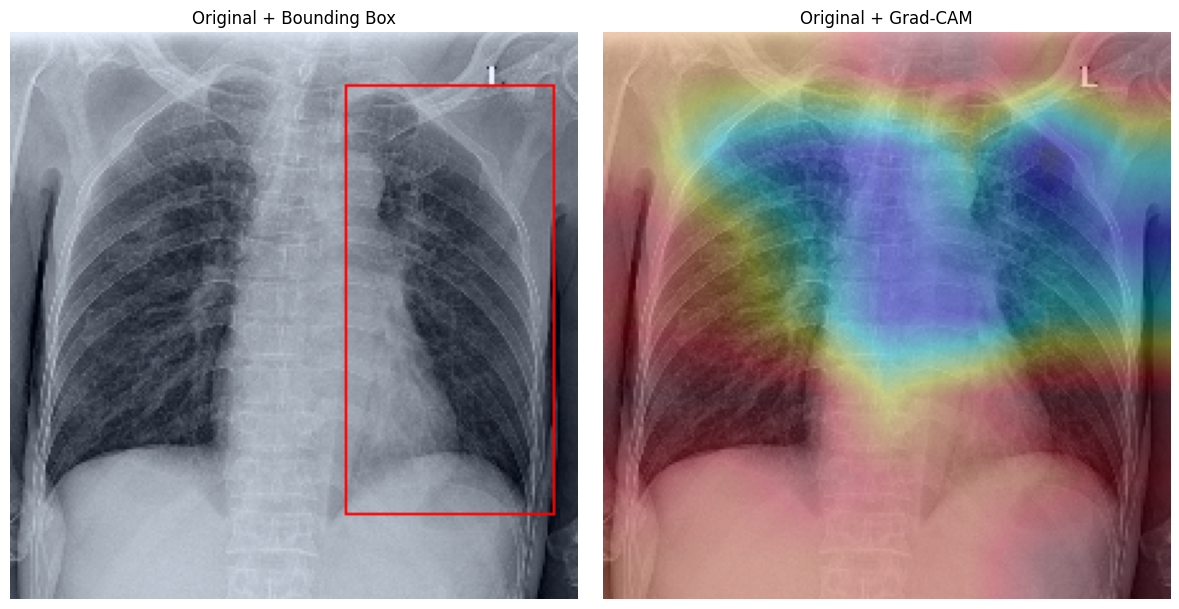

/home/common/data_v3/vinbig/fb8e11c6b2886b2d41b379e0598669b9.jpg
tensor([135.1389,  68.2889, 157.1111,  90.4556])
Prediction: Abnormal, Actual: Abnormal, Prob: 0.9996
(224, 224, 3)


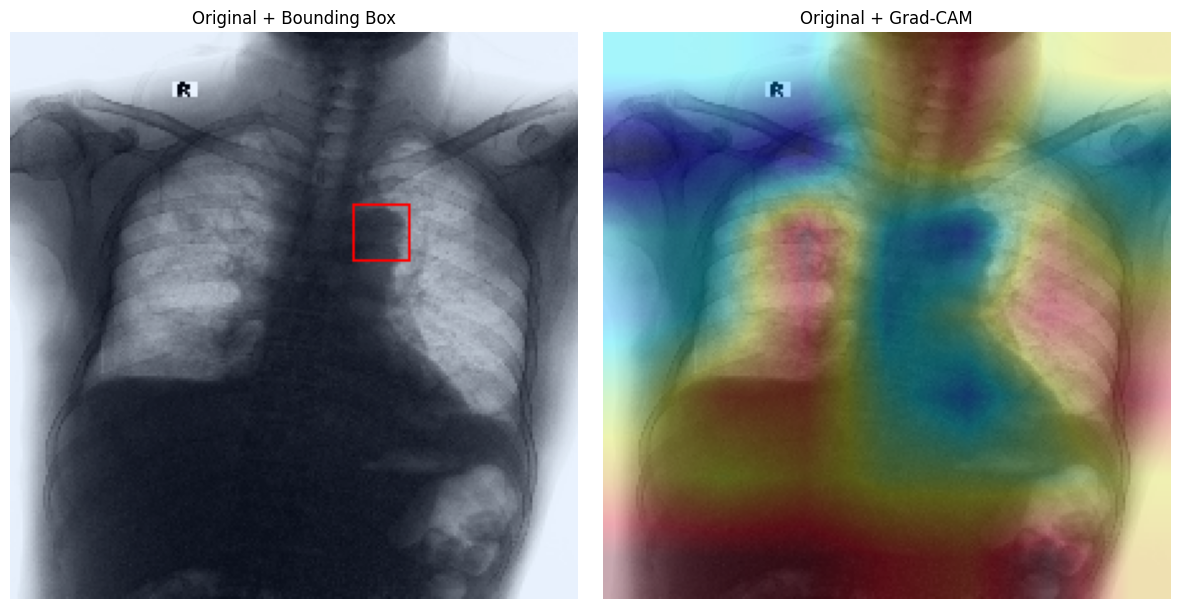

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


/home/common/data_v3/vinbig/e4b12e030788bbd71f7ad72fa1ee5a71.jpg
tensor([nan, nan, nan, nan])
Prediction: Normal, Actual: Normal, Prob: 0.2384
(224, 224, 3)


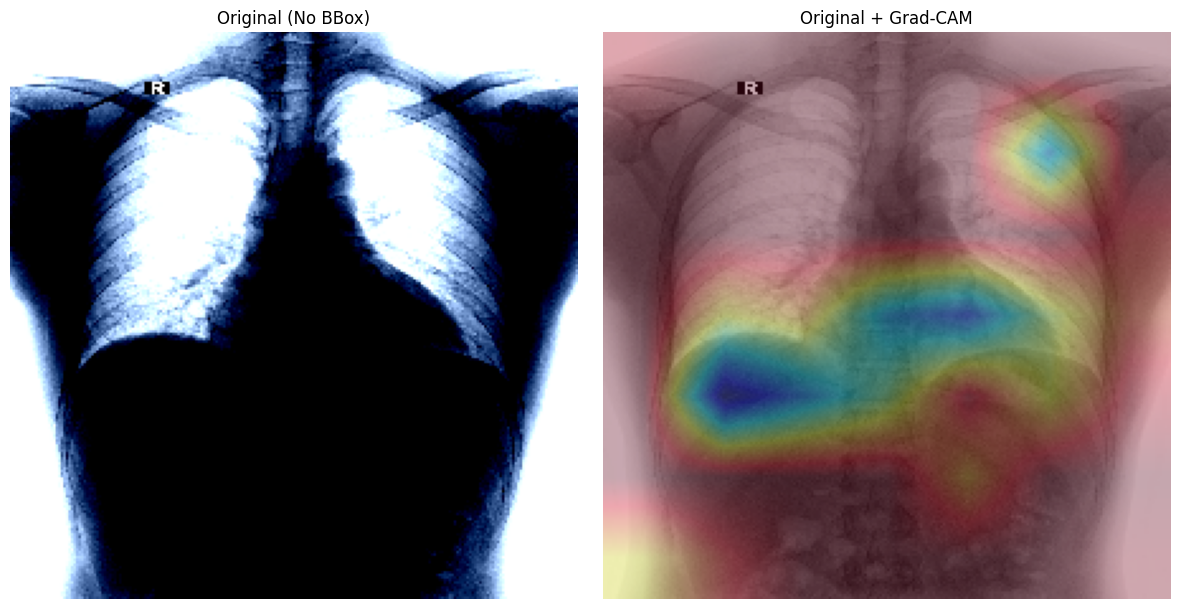

/home/common/data_v3/vinbig/222b7757f55bee221e7aba69fc9928d0.jpg
tensor([126.3748,  57.7500, 149.8331,  84.8750])
Prediction: Abnormal, Actual: Abnormal, Prob: 0.9998
(224, 224, 3)


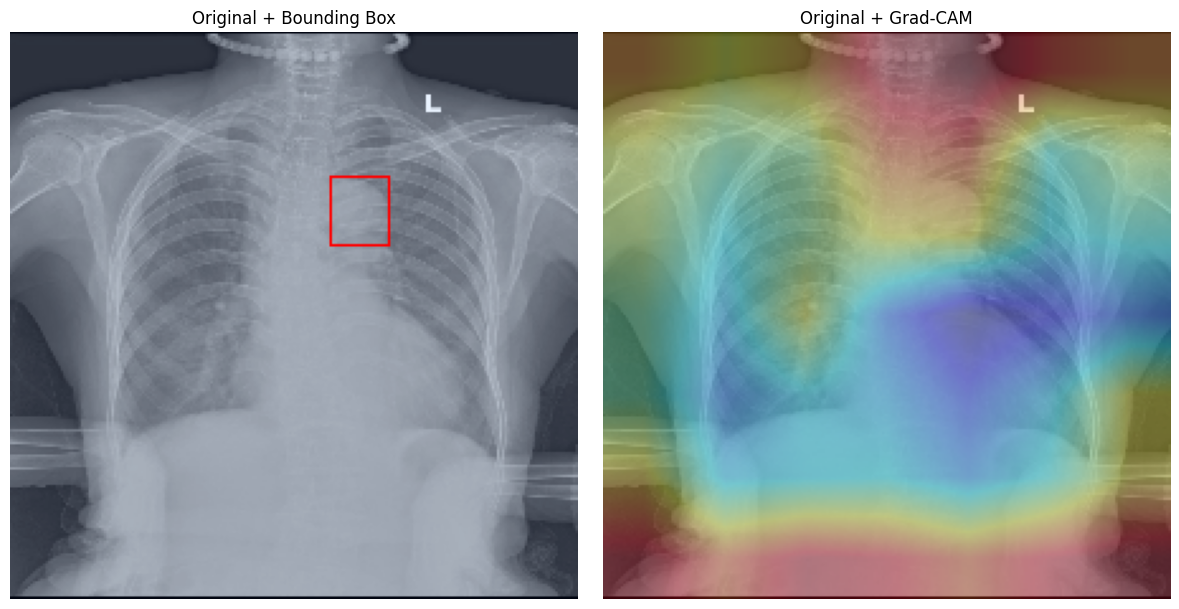

/home/common/data_v3/vinbig/9b9f47628be6a48ddb41aec8ba39b454.jpg
tensor([193.6667, 141.3333, 205.5362, 161.0833])
Prediction: Abnormal, Actual: Abnormal, Prob: 0.9909
(224, 224, 3)


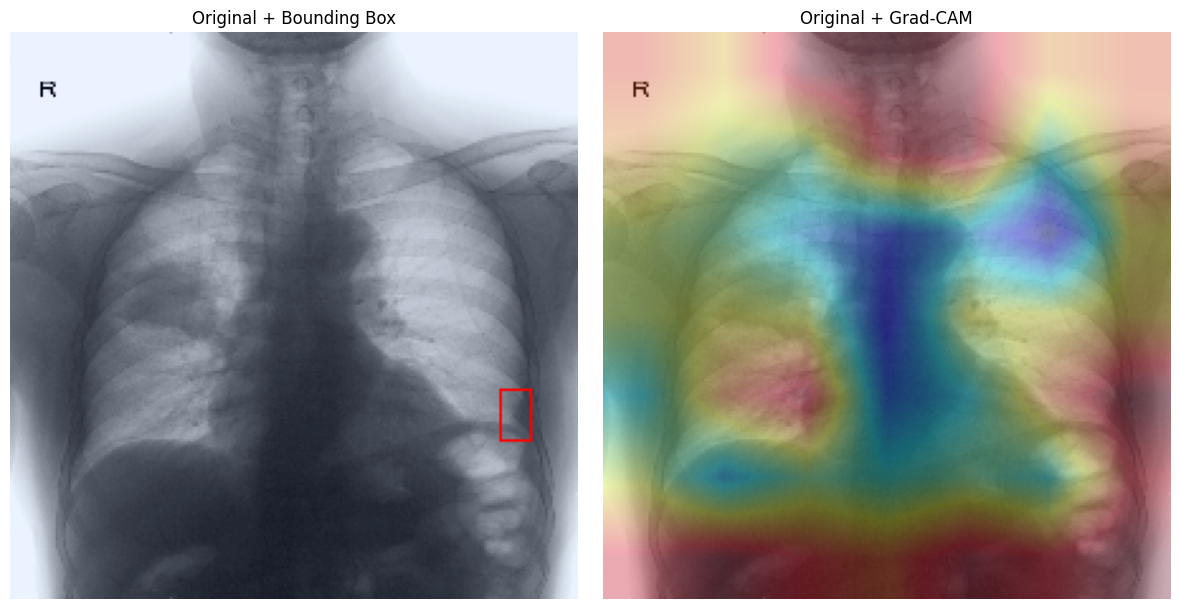

/home/common/data_v3/vinbig/b9f09915187c2cc01e958da90d97ac89.jpg
tensor([121.3698,  56.4610, 158.5574,  88.0721])
Prediction: Abnormal, Actual: Abnormal, Prob: 0.9955
(224, 224, 3)


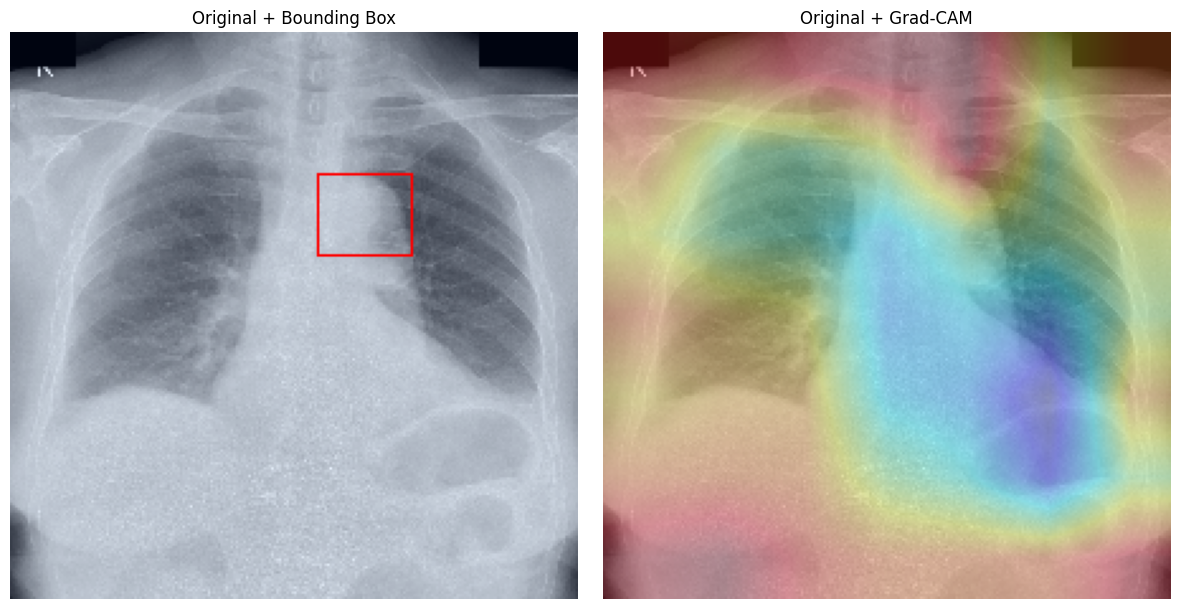

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


/home/common/data_v3/vinbig/e3ac18fd134bcb699760db4ef362e14f.jpg
tensor([nan, nan, nan, nan])
Prediction: Normal, Actual: Normal, Prob: 0.0593
(224, 224, 3)


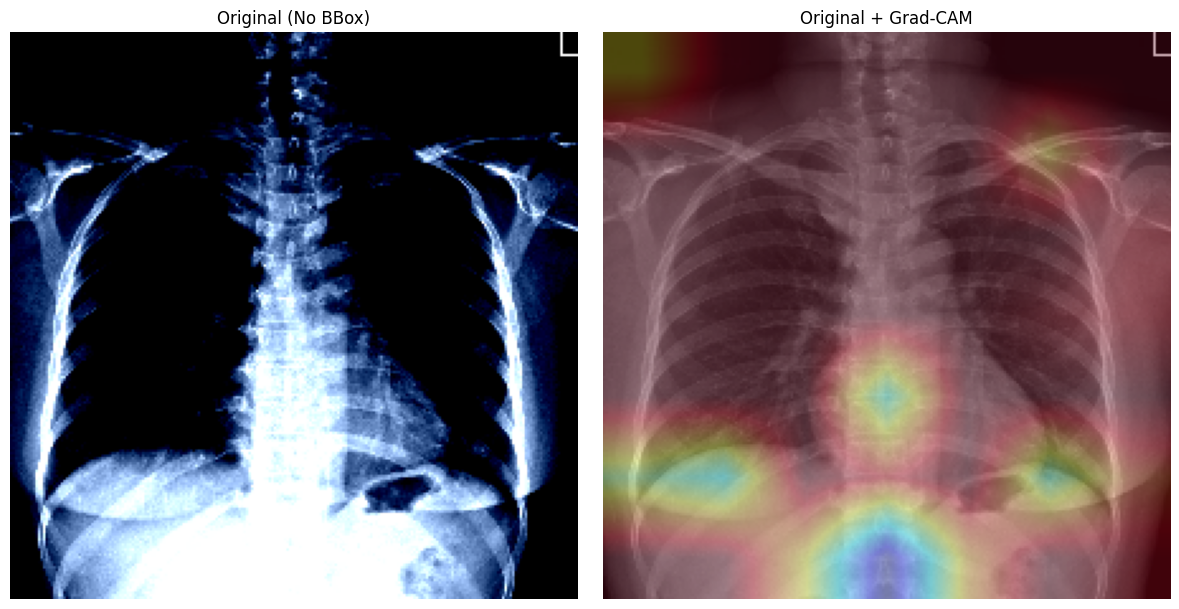

/home/common/data_v3/vinbig/a3f5ac68c8d1b1805be21f18c47fc186.jpg
tensor([167.3300,  67.2292, 176.0000,  73.6458])
Prediction: Abnormal, Actual: Abnormal, Prob: 0.9871
(224, 224, 3)


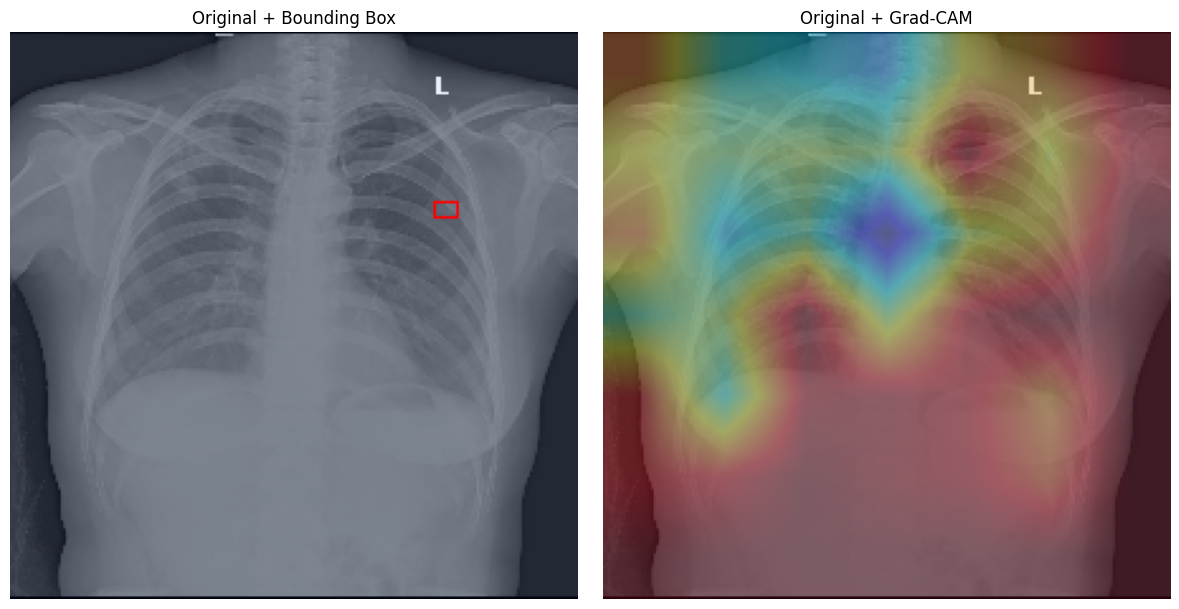

/home/common/data_v3/vinbig/aa3535cb70d8142fdbdac165de546a8c.jpg
tensor([118.4589,  65.7841, 149.4250,  93.3113])
Prediction: Abnormal, Actual: Abnormal, Prob: 0.9963
(224, 224, 3)


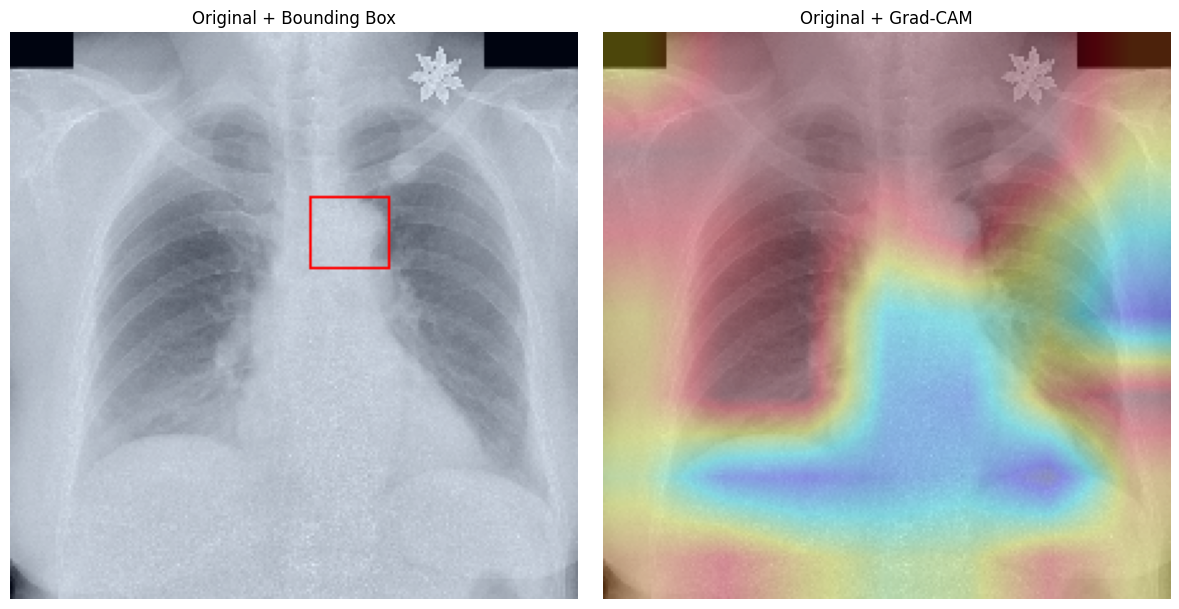

/home/common/data_v3/vinbig/ebf4ffbcf6de699bf9deab70f0dee8ff.jpg
tensor([ 70.6096, 139.2308, 188.2922, 200.7692])
Prediction: Abnormal, Actual: Abnormal, Prob: 0.9983
(224, 224, 3)


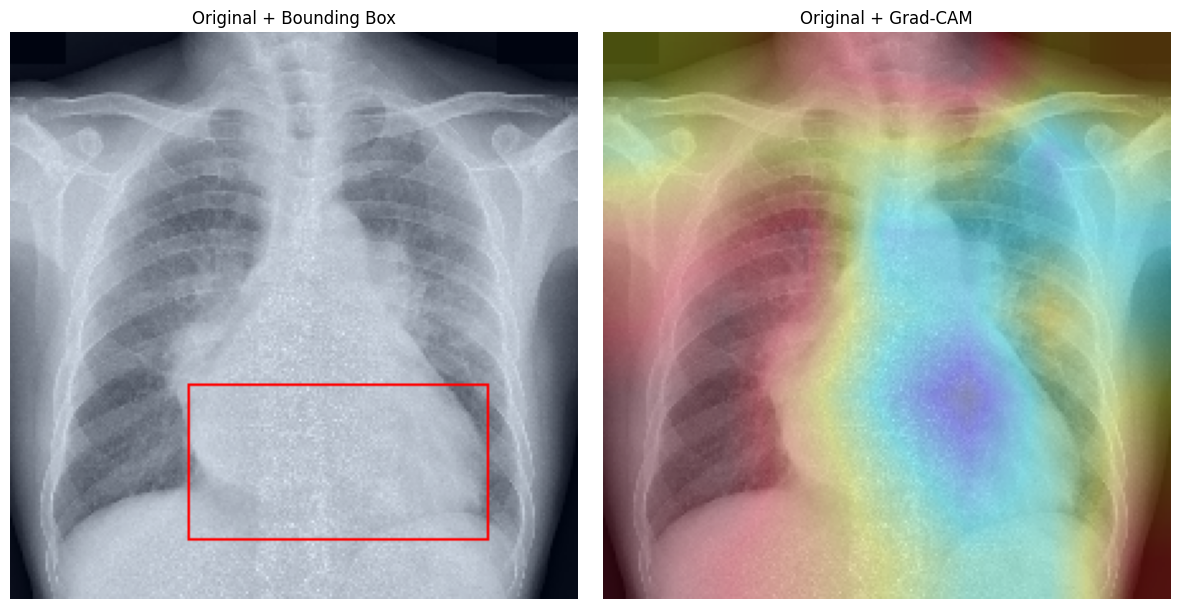

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# target_layer = model.backbone.features.norm5
target_layer = model.backbone.features.denseblock4
gradcam = GradCAM(model, target_layer)

for i in range(10):
    image, disease_id, label, bbox, has_bbox = test_dataset[i]
    print(bbox)

    label = label.item()
    image = image.unsqueeze(0).to(device)

    # ---- Forward (NO torch.no_grad) ----
    logits = model(image)
    prob = torch.sigmoid(logits).item()
    pred = int(prob > 0.5)

    label_map = {0: "Normal", 1: "Abnormal"}
    print(f"Prediction: {label_map[pred]}, Actual: {label_map[label]}, Prob: {prob:.4f}")

    # ---- Grad-CAM ----
    cam = gradcam.generate(image)
    heatmap_overlay = overlay_heatmap(cam, image)
    print(heatmap_overlay.shape)

    # # ---- BBox ----
    bbox_img = None
    if is_valid_bbox(bbox):
        bbox_img = draw_bbox(image, bbox)

    # ---- Plot ----
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    if bbox_img is not None:
        plt.imshow(bbox_img)
        plt.title("Original + Bounding Box")
    else:
        plt.imshow(image.squeeze().permute(1, 2, 0).cpu())
        plt.title("Original (No BBox)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_overlay)
    plt.title("Original + Grad-CAM")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [28]:
image, disease_id, label, bbox, has_bbox = test_dataset[0]  # choose IDX
print(disease_id, label)
image = image.unsqueeze(0).to(device)

/home/common/data_v3/vinbig/0c7a38f293d5f5e4846aa4ca6db4daf1.jpg
tensor(7) tensor(1.)


# using gradcam class

In [15]:
# image_path = '/home/common/data_v3/vinbig/0c7a38f293d5f5e4846aa4ca6db4daf1.jpg'
# image_path = '/home/common/data_v3/vinbig/fb8e11c6b2886b2d41b379e0598669b9.jpg'
# image_path = '/home/common/data_v3/vinbig/e4b12e030788bbd71f7ad72fa1ee5a71.jpg'
# image_path = '/home/common/data_v3/vinbig/222b7757f55bee221e7aba69fc9928d0.jpg'
# image_path = '/home/common/data_v3/vinbig/9b9f47628be6a48ddb41aec8ba39b454.jpg'
# image_path = '/home/common/data_v3/vinbig/b9f09915187c2cc01e958da90d97ac89.jpg'
# image_path = '/home/common/data_v3/vinbig/e3ac18fd134bcb699760db4ef362e14f.jpg'
# image_path = '/home/common/data_v3/vinbig/a3f5ac68c8d1b1805be21f18c47fc186.jpg'
# image_path = '/home/common/data_v3/vinbig/aa3535cb70d8142fdbdac165de546a8c.jpg'
image_path = '/home/common/data_v3/vinbig/ebf4ffbcf6de699bf9deab70f0dee8ff.jpg'

image = Image.open(image_path).convert("RGB")
image = np.array(image)
augmented_image = train_transform_nobbox(image=image)
image_tensor = augmented_image["image"].unsqueeze(0).to(device)

logits = model(image_tensor)                 
prob = torch.sigmoid(logits).item()  
pred = 1 if prob > 0.5 else 0
    
label_map = {0: "Normal", 1: "Abnormal"}
result = label_map[pred]

print(prob, result)

target_layer = model.backbone.features.denseblock4
gradcam = GradCAM(model, target_layer)
cam = gradcam.generate(image_tensor)

# orig = np.array(image.resize((224, 224)))

orig = image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

orig = orig * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
orig = np.clip(orig, 0, 1)
orig = np.uint8(255 * orig)


heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = np.uint8(0.5 * orig + 0.5 * heatmap)

# image_tensor.shape

0.9983179569244385 Abnormal


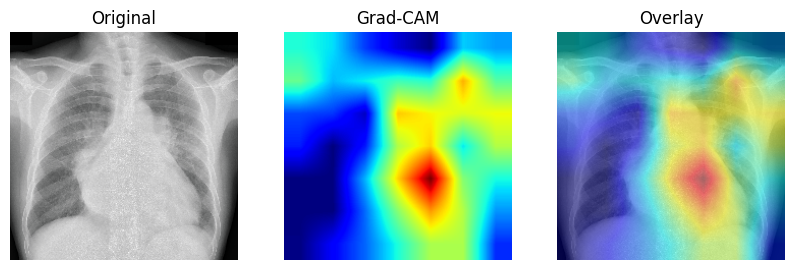

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(orig)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM")
plt.imshow(cam, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()

# using captum

In [44]:
csv= '/home/jupyter-nafisha/normal-abnormal-multitask/CSVs/vinbig_test_withBBox.csv'
data = pd.read_csv(csv)
data.columns

Index(['Unnamed: 0', 'image_id', 'sex', 'orientation', 'x_min', 'y_min',
       'x_max', 'y_max', 'class_name', 'label'],
      dtype='object')

In [61]:
import pandas as pd

def get_bboxes_for_image(csv_path, image_id):
    """
    Returns a list of bounding boxes for a given image_id.
    Each bounding box is [x_min, y_min, x_max, y_max].
    """
    df = pd.read_csv(csv_path)

    boxes = df[df["image_id"] == image_id][
        ["x_min", "y_min", "x_max", "y_max"]
    ].values.tolist()

    return boxes

image_path = 'vinbig/e4b12e030788bbd71f7ad72fa1ee5a71.jpg'
get_bboxes_for_image(csv, image_path)

[[nan, nan, nan, nan]]

In [117]:
from captum.attr import LayerGradCam
from transform import val_transform, train_transform_bbox, train_transform_nobbox

# image_path = '/home/common/data_v3/vinbig/0c7a38f293d5f5e4846aa4ca6db4daf1.jpg'
# bbox= [[161.0,56.0,2117.0,2213.0], [87.0,196.0,1013.0,2129.0], [1347.0,245.0,2188.0,2169.0], [458.0,792.0,669.0,962.0]]

image_path = '/home/common/data_v3/vinbig/fb8e11c6b2886b2d41b379e0598669b9.jpg'
bbox = [[1390.0, 878.0, 1616.0, 1163.0],
 [1941.0, 1896.0, 2112.0, 2103.0],
 [597.0, 1445.0, 933.0, 1756.0],
 [649.0, 869.0, 833.0, 1021.0],
 [677.0, 458.0, 1055.0, 619.0],
 [663.0, 899.0, 793.0, 1025.0],
 [663.0, 899.0, 793.0, 1025.0],
 [222.0, 1658.0, 390.0, 1959.0],
 [698.0, 459.0, 1064.0, 605.0],
 [649.0, 869.0, 833.0, 1021.0],
 [1328.0, 913.0, 1603.0, 1260.0],
 [660.0, 899.0, 812.0, 1016.0],
 [590.0, 587.0, 996.0, 1035.0],
 [1941.0, 1896.0, 2112.0, 2103.0],
 [452.0, 1411.0, 1046.0, 1777.0],
 [569.0, 1463.0, 951.0, 1775.0],
 [704.0, 479.0, 1081.0, 580.0],
 [603.0, 723.0, 990.0, 1241.0],
 [222.0, 1658.0, 390.0, 1959.0],
 [597.0, 1445.0, 933.0, 1756.0]]       

# image_path = '/home/common/data_v3/vinbig/e4b12e030788bbd71f7ad72fa1ee5a71.jpg'
# bbox = []

# image_path = '/home/common/data_v3/vinbig/222b7757f55bee221e7aba69fc9928d0.jpg'
# bbox = [[1433.0, 792.0, 1699.0, 1164.0],
#  [1341.0, 808.0, 1698.0, 1165.0],
#  [1044.0, 542.0, 1191.0, 1098.0],
#  [993.0, 1640.0, 2046.0, 2149.0],
#  [1376.0, 792.0, 1699.0, 1151.0],
#  [981.0, 1750.0, 2034.0, 2136.0],
#  [971.0, 1790.0, 2028.0, 2142.0],
#  [1044.0, 542.0, 1191.0, 1098.0]]

# image_path = '/home/common/data_v3/vinbig/9b9f47628be6a48ddb41aec8ba39b454.jpg'
# bbox = [[1909.0, 1696.0, 2026.0, 1933.0],
#  [1160.0, 853.0, 1458.0, 1224.0],
#  [1170.0, 850.0, 1470.0, 1223.0],
#  [1909.0, 1696.0, 2026.0, 1933.0],
#  [399.0, 1064.0, 817.0, 1442.0],
#  [399.0, 1064.0, 817.0, 1442.0],
#  [1379.0, 1831.0, 2064.0, 2151.0],
#  [380.0, 1095.0, 821.0, 1466.0],
#  [768.0, 1640.0, 1778.0, 1997.0],
#  [380.0, 1095.0, 821.0, 1466.0],
#  [435.0, 1088.0, 823.0, 1462.0],
#  [399.0, 1064.0, 817.0, 1442.0],
#  [1154.0, 867.0, 1457.0, 1225.0],
#  [380.0, 1095.0, 821.0, 1466.0]]

# image_path = '/home/common/data_v3/vinbig/b9f09915187c2cc01e958da90d97ac89.jpg'
# bbox = [[1250.0, 643.0, 1633.0, 1003.0],
#  [1304.0, 641.0, 1647.0, 1054.0],
#  [1266.0, 626.0, 1595.0, 1180.0],
#  [99.0, 1588.0, 256.0, 1866.0],
#  [2040.0, 1601.0, 2185.0, 1758.0],
#  [805.0, 1459.0, 1947.0, 1799.0],
#  [776.0, 1401.0, 1985.0, 1774.0],
#  [749.0, 253.0, 903.0, 320.0],
#  [2040.0, 1601.0, 2185.0, 1758.0],
#  [99.0, 1588.0, 256.0, 1866.0],
#  [792.0, 1509.0, 1991.0, 1711.0]]

# image_path = '/home/common/data_v3/vinbig/e3ac18fd134bcb699760db4ef362e14f.jpg'
# bbox = []

# image_path = '/home/common/data_v3/vinbig/a3f5ac68c8d1b1805be21f18c47fc186.jpg'
# bbox = [[2123.0, 922.0, 2233.0, 1010.0],
#  [750.0, 474.0, 1149.0, 891.0],
#  [784.0, 761.0, 947.0, 884.0],
#  [793.0, 767.0, 950.0, 893.0],
#  [2126.0, 917.0, 2270.0, 984.0],
#  [2065.0, 896.0, 2299.0, 1016.0],
#  [830.0, 522.0, 987.0, 719.0],
#  [829.0, 555.0, 987.0, 750.0]]

# image_path = '/home/common/data_v3/vinbig/aa3535cb70d8142fdbdac165de546a8c.jpg'
# bbox = [[1293.0, 748.0, 1631.0, 1061.0],
#  [1362.0, 757.0, 1625.0, 1037.0],
#  [1622.0, 557.0, 1767.0, 685.0],
#  [954.0, 1590.0, 2060.0, 1974.0],
#  [1623.0, 539.0, 1774.0, 689.0],
#  [1635.0, 546.0, 1775.0, 694.0],
#  [1622.0, 557.0, 1767.0, 685.0],
#  [740.0, 302.0, 1056.0, 378.0],
#  [1333.0, 771.0, 1657.0, 1131.0],
#  [965.0, 1646.0, 2086.0, 2030.0],
#  [2065.0, 1640.0, 2173.0, 1738.0],
#  [2081.0, 1829.0, 2157.0, 1899.0],
#  [963.0, 1672.0, 2062.0, 2032.0],
#  [1457.0, 286.0, 1681.0, 410.0]]

# image_path = '/home/common/data_v3/vinbig/ebf4ffbcf6de699bf9deab70f0dee8ff.jpg'
# bbox= [[876.0, 1810.0, 2336.0, 2610.0],
#  [2080.0, 1202.0, 2443.0, 1824.0],
#  [1394.0, 888.0, 1759.0, 1240.0],
#  [864.0, 1869.0, 2333.0, 2436.0],
#  [858.0, 1584.0, 2342.0, 2455.0],
#  [780.0, 1415.0, 1029.0, 1866.0]]

image = Image.open(image_path).convert("RGB")
image = np.array(image)
augmented_image = train_transform_nobbox(image=image)
image_tensor = augmented_image["image"].unsqueeze(0).to(device)

# Choose final conv layer in DenseNet201 (last layer in last dense block)
target_layer = model.backbone.features.denseblock4
gradcam = LayerGradCam(model, target_layer)

# Get Grad-CAM attribution for regression output
attribution = gradcam.attribute(image_tensor, target=0)
attr_map = attribution.squeeze().detach().cpu().numpy()

In [118]:
attr_map = np.maximum(attr_map, 0)  # ReLU (important)
attr_map = attr_map / (attr_map.max() + 1e-8)

# Resize to model input size (224x224)
heatmap = cv2.resize(attr_map, (224, 224))

# Convert tensor to numpy
img_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

# Undo normalization (ImageNet)
mean = np.array([0.485, 0.485, 0.485])
std = np.array([0.229, 0.229, 0.229])
img_np = (img_np * std) + mean
img_np = np.clip(img_np, 0, 1)


heatmap_color = cv2.applyColorMap(
    np.uint8(255 * heatmap),
    cv2.COLORMAP_JET
)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
heatmap_color = heatmap_color / 255.0

overlay = 0.5 * img_np + 0.5 * heatmap_color
overlay = np.clip(overlay, 0, 1)

In [119]:
# plt.figure(figsize=(6,6))
# plt.imshow(overlay)
# plt.axis("off")
# plt.title("Grad-CAM Overlay")
# plt.show()

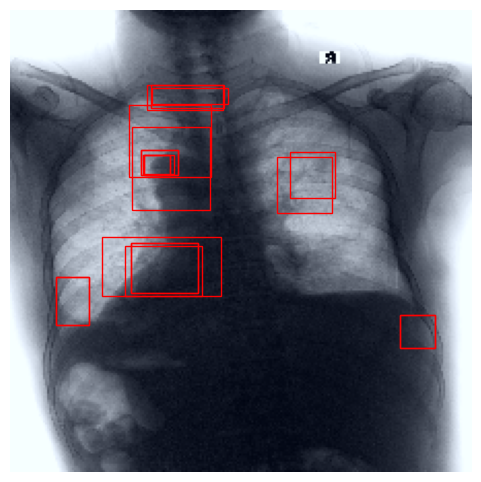

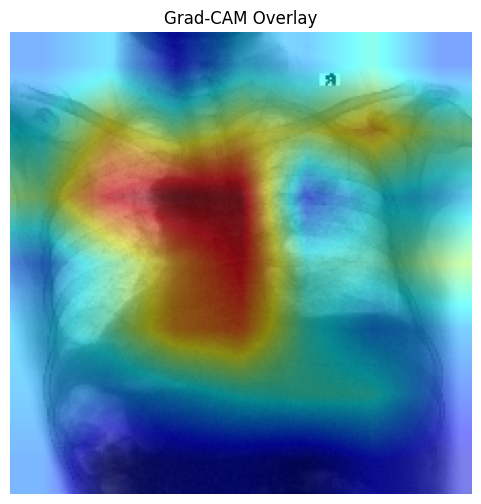

In [120]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(img_np)
ax.axis("off")

H_orig, W_orig = image.shape[:2]
sx = 224 / W_orig
sy = 224 / H_orig

for box in bbox:
    x1, y1, x2, y2 = box
    rect = patches.Rectangle(
        (x1 * sx, y1 * sy),
        (x2 - x1) * sx,
        (y2 - y1) * sy,
        linewidth=1,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.show()


plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM Overlay")
plt.show()

In [82]:
bbox

[[2123.0, 922.0, 2233.0, 1010.0],
 [750.0, 474.0, 1149.0, 891.0],
 [784.0, 761.0, 947.0, 884.0],
 [793.0, 767.0, 950.0, 893.0],
 [2126.0, 917.0, 2270.0, 984.0],
 [2065.0, 896.0, 2299.0, 1016.0],
 [830.0, 522.0, 987.0, 719.0],
 [829.0, 555.0, 987.0, 750.0]]